# Predicting Missing Fitbit Data

## Summary of Findings

---
## Project Plan

### Goals
 - Predict missing values from the data set using clustering
 - Derive insights on "Armstrong", the person from whom the fitness data was generated

### Hypotheses
 - There are patterns on Armstrong's daily activities.
 - Armstrong's fitness activity is affected by the month/season of the year.

### Data Science Skills Used
 - Data prep and cleaning
 - Time Series Analysis
 - Visualization
 - Modeling using Parametric Methods
 - Modeling using the Prophet algorithm
 - Evaluation of Models

---
## Data Dictionary

---
## Notes on the Fitbit Data:

We are given eight .csv files that hold monthly data of an individual, whom we elect to call "Armstrong". Before we begin wrangling the data, we peruse all the files and made initial notes as follows:

1. The "missing" data is from 6/27/2018 - 7/6/2018 on the following variables:
  - Steps
  - Distance
  - Floors
  - Lightly Active in Minutes
  - Fairly Active in Minutes
  - Very Active in Minutes
2. Food/ Food log data is almost empty. There are only 1 record available in May-June data, and 7 records in the October-November data.
3. The data range covers April 26, 2018 to December 6, 2018.

### Packages

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
#import prepare
#import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
# from summarize import df_summary

## I. Acquire and Preprocess

We manipulated the individual csv files from Excel, and decided to create a single .csv file as the size of the data is manageable. We only wanted the activity data, and not the food/food log data which barely contain any data.

`act.csv` is the csv file that integrates all relevant activitiy data from the eight .csv files provided.

The `acquire` function from the acquire.py module produces a data frame out of `act.csv` and renames the columns for efficiency.

In [2]:
df = pd.read_csv('act.csv', header=0,usecols=[0,1,2,3,4,5,6,7,8,9],names=["date","cal_burn","steps","distance","floors","min_sed","min_active_light","min_active_fairly","min_active_very","cal_activity"])

In [3]:
df.head()

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [4]:
# #### acquire function broke!!!
# df = acquire.acquire()

# #Initial look at the data.
# #Catch presence of nulls and inappropriate data types
# df.info()

Apart from `date` which will be handled later, there are four columns that are object type.
 - cal_burn
 - steps
 - min_sed
 - cal_activity

In [5]:
df.sample(5) #inspect the object-type attributes

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
12,5/8/18,"2,591","1,187",0.56,2,"1,221",53,17,2,410
7,5/3/18,"3,121","2,232",1.05,0,876,157,16,0,"1,006"
124,8/28/18,"3,757","12,569",5.93,14,717,218,8,58,"1,874"
35,5/31/18,"3,420","5,879",2.77,3,735,230,5,6,"1,349"
179,10/22/18,"3,149","8,328",3.93,7,747,172,4,28,"1,239"


It seems that commas are making these numeric attributes as object types. To remove commas and cast these columns from object into integer types, call the `handle_obj_type` function from the acquire.py module.

In [6]:
df = acquire.handle_obj_type(df)

In [7]:
df = acquire.basic_clean(df)

Total length of df is: 225
Total length of non-repeating dates is: 225


In [8]:
def split_store_data(df, train_prop=.7): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [9]:
train, test = split_store_data(df, train_prop=.7)

In [10]:
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 157
Testing Observations: 68


In [11]:
# train = (df.loc[:int(len(df)*.70)])
# test = (df.loc[train.shape[0]:])

In [12]:
# train.date = pd.to_datetime(train.date)
# test.date = pd.to_datetime(test.date)
# train = train.set_index("date")
# test = test.set_index("date")

In [13]:
train = train.set_index('date')
test = test.set_index('date')

In [14]:
train.head(1)

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566


Finally, to facilitate our analysis, cast `date` column into datetime data type, and set it as the index of our data frame. Call `basic_clean` function to execute these, as well as validate that the days are distinct, i.e. no duplicate records.

### Split Data

Split the data into train and test using the `split_date` from the acquire module.
  
**Composition of Test and Train**    
**Test**
 - April 26 to July 15, 2018
 - Includes the period of missing values, June 27 to July 6, 2018  

**Train**
 - July 16 to Dec 6, 2018

In [15]:
target_vars = train.columns.to_list()

In [16]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [83]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse
    
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

def plot_and_eval(target_vars, train = train, test = test,metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    #plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))
    
    plt.show()
    


In [84]:
def last_observed():
    yhat = pd.DataFrame(test[target_vars])
    for var in target_vars:
        yhat[var] = int(train[var][-1:])
    eval_df = append_eval_df('last_observed', target_vars, train = train, test = test)
    return eval_df

In [85]:
last_observed()

,model_type,target_var,metric,value
0,holts_exponential_trend,cal_burn,mse,1.169514e+06
1,holts_exponential_trend,cal_burn,rmse,1.081441e+03
2,holts_exponential_trend,steps,mse,8.585202e+07
3,holts_exponential_trend,steps,rmse,9.265637e+03
4,holts_exponential_trend,distance,mse,1.995392e+01
5,holts_exponential_trend,distance,rmse,4.466981e+00
6,holts_exponential_trend,floors,mse,4.987490e+03
7,holts_exponential_trend,floors,rmse,7.062216e+01
8,holts_exponential_trend,min_sed,mse,2.569075e+04
9,holts_exponential_trend,min_sed,rmse,1.602834e+02


In [50]:
def simple_avg():
    yhat = pd.DataFrame(test[target_vars])
    for var in target_vars:
        yhat[var] = train[var].mean()
    eval_df = append_eval_df('simple_avg', target_vars, train = train, test = test)
    return eval_df

In [51]:
simple_avg()

,model_type,target_var,metric,value
0,simple_avg,cal_burn,mse,3.815530e+05
1,simple_avg,cal_burn,rmse,6.176997e+02
2,simple_avg,steps,mse,5.707205e+07
3,simple_avg,steps,rmse,7.554604e+03
4,simple_avg,distance,mse,1.319972e+01
5,simple_avg,distance,rmse,3.633143e+00
6,simple_avg,floors,mse,1.939545e+03
7,simple_avg,floors,rmse,4.404026e+01
8,simple_avg,min_sed,mse,5.567194e+04
9,simple_avg,min_sed,rmse,2.359490e+02


In [54]:
def moving_avg():
    periods = 30
    periods = 30
    for var in target_vars:
        yhat[var] = train[var].rolling(periods).mean().iloc[-1]

    plot_and_eval(target_vars, train, test)
    eval_df1 = append_eval_df(model_type='moving_average', target_vars=target_vars, train = train, test = test)

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')
    period_vals = [1, 4, 12, 26, 52, 104]
    for p in period_vals:
        for var in target_vars:
            yhat[var] = train[var].rolling(p).mean().iloc[-1]
            plt.plot(yhat[var])
            print('\nrolling averge period:',p)
            print(var)
            evaluate(var, train = train, test = test)
    eval_df2 = append_eval_df('moving_avg', target_vars, train = train, test = test)
    return eval_df1, eval_df2

cal_burn -- MSE: 387278.97 RMSE: 622.32
steps -- MSE: 43460991.94 RMSE: 6592.50
distance -- MSE: 10.05 RMSE: 3.17
floors -- MSE: 1746.50 RMSE: 41.79
min_sed -- MSE: 26159.07 RMSE: 161.74
min_active_light -- MSE: 4209.76 RMSE: 64.88
min_active_fairly -- MSE: 319.47 RMSE: 17.87
min_active_very -- MSE: 2314.77 RMSE: 48.11
cal_activity -- MSE: 647276.63 RMSE: 804.54


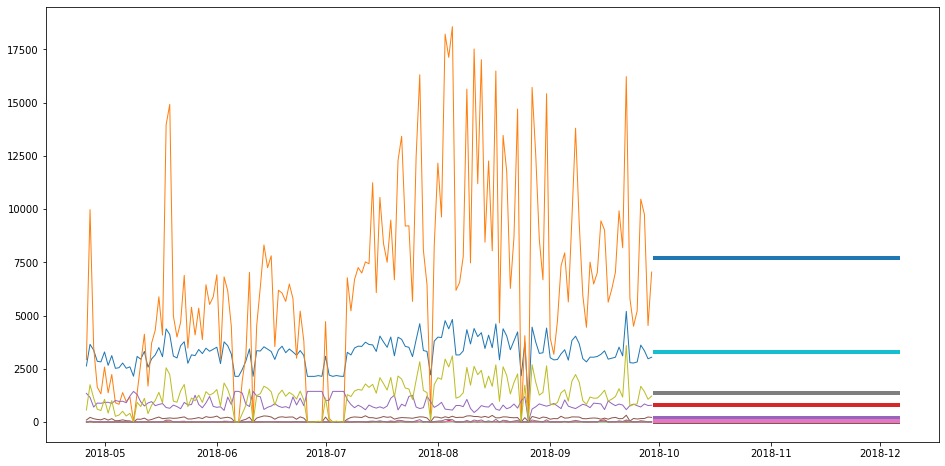


rolling averge period: 1
cal_burn
MSE:  630620.4264705882
RMSE: 794.1161290835165

rolling averge period: 1
steps
MSE:  51102765.85294118
RMSE: 7148.619856513646

rolling averge period: 1
distance
MSE:  11.876647058823556
RMSE: 3.4462511601483077

rolling averge period: 1
floors
MSE:  2023.2941176470588
RMSE: 44.981041758134715

rolling averge period: 1
min_sed
MSE:  27571.191176470587
RMSE: 166.04575025115994

rolling averge period: 1
min_active_light
MSE:  2840.176470588235
RMSE: 53.293306057967875

rolling averge period: 1
min_active_fairly
MSE:  500.4264705882353
RMSE: 22.37021391467313

rolling averge period: 1
min_active_very
MSE:  4366.632352941177
RMSE: 66.08049903671413

rolling averge period: 1
cal_activity
MSE:  823551.2794117647
RMSE: 907.4972613797602

rolling averge period: 4
cal_burn
MSE:  407735.1911764706
RMSE: 638.5414561142218

rolling averge period: 4
steps
MSE:  40994459.78308824
RMSE: 6402.691604558839

rolling averge period: 4
distance
MSE:  9.558441176470605
RM

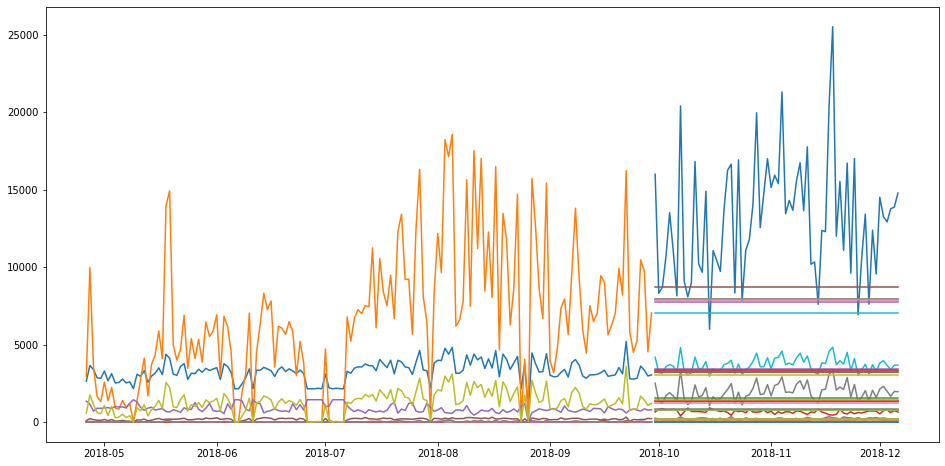

In [56]:
eval_df1, eval_df2 = moving_avg()

In [57]:
eval_df1

,model_type,target_var,metric,value
0,moving_average,cal_burn,mse,3.872790e+05
1,moving_average,cal_burn,rmse,6.223174e+02
2,moving_average,steps,mse,4.346099e+07
3,moving_average,steps,rmse,6.592495e+03
4,moving_average,distance,mse,1.005252e+01
5,moving_average,distance,rmse,3.170571e+00
6,moving_average,floors,mse,1.746504e+03
7,moving_average,floors,rmse,4.179120e+01
8,moving_average,min_sed,mse,2.615907e+04
9,moving_average,min_sed,rmse,1.617376e+02


In [58]:
eval_df2

,model_type,target_var,metric,value
0,moving_avg,cal_burn,mse,3.110555e+05
1,moving_avg,cal_burn,rmse,5.577235e+02
2,moving_avg,steps,mse,4.309857e+07
3,moving_avg,steps,rmse,6.564950e+03
4,moving_avg,distance,mse,1.001799e+01
5,moving_avg,distance,rmse,3.165121e+00
6,moving_avg,floors,mse,1.863842e+03
7,moving_avg,floors,rmse,4.317224e+01
8,moving_avg,min_sed,mse,4.313616e+04
9,moving_avg,min_sed,rmse,2.076925e+02


In [69]:
def holt_linear():
    from statsmodels.tsa.api import Holt

    for var in target_vars:
        model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
        yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

    #plot_and_eval(target_vars, train, test)
        eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)
    return eval_df

In [70]:
holt_linear()

,model_type,target_var,metric,value
0,holts_linear_trend,cal_burn,mse,1.169514e+06
1,holts_linear_trend,cal_burn,rmse,1.081441e+03
2,holts_linear_trend,steps,mse,8.585202e+07
3,holts_linear_trend,steps,rmse,9.265637e+03
4,holts_linear_trend,distance,mse,1.995392e+01
5,holts_linear_trend,distance,rmse,4.466981e+00
6,holts_linear_trend,floors,mse,4.987490e+03
7,holts_linear_trend,floors,rmse,7.062216e+01
8,holts_linear_trend,min_sed,mse,2.569075e+04
9,holts_linear_trend,min_sed,rmse,1.602834e+02


In [78]:
def holt_exp():
    for var in target_vars:
        from statsmodels.tsa.holtwinters import ExponentialSmoothing
        model = ExponentialSmoothing(train[var], trend= 'additive').fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
        yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

    #plot_and_eval(target_vars, train, test)
        eval_df = append_eval_df(model_type='holts_exponential_trend', target_vars=target_vars, train = train, test = test)
    return eval_df

In [79]:
holt_exp()

,model_type,target_var,metric,value
0,holts_exponential_trend,cal_burn,mse,1.169514e+06
1,holts_exponential_trend,cal_burn,rmse,1.081441e+03
2,holts_exponential_trend,steps,mse,8.585202e+07
3,holts_exponential_trend,steps,rmse,9.265637e+03
4,holts_exponential_trend,distance,mse,1.995392e+01
5,holts_exponential_trend,distance,rmse,4.466981e+00
6,holts_exponential_trend,floors,mse,4.987490e+03
7,holts_exponential_trend,floors,rmse,7.062216e+01
8,holts_exponential_trend,min_sed,mse,2.569075e+04
9,holts_exponential_trend,min_sed,rmse,1.602834e+02


In [46]:
def TS_loopy():
    model_list = ['last_observed','simple_avg']
    for model_type in model_list:
        if model_type == 'last_observed':
            yhat = last_observed()
            #plot_and_eval(target_vars=target_vars, train = train, test = test)
            eval_df = append_eval_df(model_type, target_vars, train = train, test = test)
            if model_type == 'simple_avg':
                yhat_sa = simple_avg()
                eval_df = append_eval_df(model_type, target_vars, train = train, test = test)
                
    return eval_df

In [47]:
TS_loopy()

,model_type,target_var,metric,value
0,last_observed,cal_burn,mse,3.815530e+05
1,last_observed,cal_burn,rmse,6.176997e+02
2,last_observed,steps,mse,5.707205e+07
3,last_observed,steps,rmse,7.554604e+03
4,last_observed,distance,mse,1.319972e+01
5,last_observed,distance,rmse,3.633143e+00
6,last_observed,floors,mse,1.939545e+03
7,last_observed,floors,rmse,4.404026e+01
8,last_observed,min_sed,mse,5.567194e+04
9,last_observed,min_sed,rmse,2.359490e+02


In [ ]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

In [ ]:
#eval_df = append_eval_df(model_type, target_vars, train = train, test = test)

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
for var in target_vars:
    yhat[var] = train[var].mean()

In [ ]:
plot_and_eval(target_vars, train = train, test = test)

In [ ]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("B").mean(), model='additive')

fig = decomposition.plot()
plt.show()

In [ ]:
train.head()

Calories Burn and Activity Calories are related.
Confirms Hypothesis that we can use the BMR calculation to impute missing values on Activity Calories.
-formula

In [ ]:
sns.lmplot(data=train,x="cal_burn",y="cal_activity")

In [ ]:
median_bmr = (train.cal_burn - train.cal_activity).median()

In [ ]:
missing_subset = train["2018-06-26":"2018-07-06"]

In [ ]:
missing_subset[missing_subset.cal_activity==0]["cal_activity"] = missing_subset.cal_burn - median_bmr

In [ ]:
missing_subset[missing_subset.cal_activity==0]["cal_activity"]

In [ ]:
for row in missing_subset:
    if row.cal_activity == 0:
        print("yes")

In [ ]:
if missing_subset.cal_activity == 0:
    missing_subset.replace(0,missing_subset.cal_burn - median_bmr,inplace=True)

In [ ]:
missing_subset

In [ ]:
train["2018-06-26":"2018-07-06"][train.cal_activity==0]["cal_activity"] = train.cal_burn - median_bmr

In [ ]:
train["2018-06-26":"2018-07-06"].cal_activity

train.cal_activity = train.cal_activity == 0]


#impute 0 cal_activity using bmr formula
missing_val.cal_activity = missing_val.cal_burn - median_bmr
missing_val.cal_activity = missing_val.cal_activity.astype("int")

In [ ]:
#get the week with missing value, then
#filter out the rows with 0 cal_activity
missing_subset = train["2018-06-26":"2018-07-06"]
missing_subset["min_active_steps"] = mean_lds_steps

In [ ]:
#impute 0 cal_activity using bmr formula
missing_val.cal_activity = missing_val.cal_burn - median_bmr
missing_val.cal_activity = missing_val.cal_activity.astype("int")

In [ ]:
train["2018-06-26":"2018-07-06"]

Now, let us see the method for imputing steps, min_act...

Lazy Days Stats

In [ ]:
mean_lds_very = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_very.mean()

In [ ]:
mean_lds_fairly = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_fairly.mean()

In [ ]:
mean_lds_light = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_light.mean()

In [ ]:
mean_lds_floor = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].floors.mean()

In [ ]:
mean_lds_distance = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].distance.mean()

In [ ]:
mean_lds_steps = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].steps.mean()

In [ ]:
sns.lmplot(data=train,x="cal_burn",y="steps")
plt.show()

In [ ]:
train.cal_burn.resample("D").mean().diff(periods=5).plot(figsize=(12,4))

In [ ]:
#get the week with missing value, then
#filter out the rows with 0 cal_activity
missing_subset = train["2018-06-26":"2018-07-06"]
missing_subset["min_active_steps"] = mean_lds_steps

In [ ]:
binned_steps = pd.cut(x=train.steps,bins=10)
binned_steps.value_counts(sort=False).plot.bar()
plt.show()

In [ ]:
train_imp_ref = train.steps.loc["2018-07":]
train_imp_ref

In [ ]:
train.steps.loc["2018-07":].groupby("weekday_name").mean()

No trend.
Yes seasonality.

## II. Explore

**Questions**

1. Are there any day of the week where Armstrong is particularly more active or sedentary?
2. Do Armstrong have weekly patterns of activity?
3. During which months is Armstrong more/less active?
4. What is Armstrong's average statistics? Use moving average, so non or less-active/non or less-recorded days will not affect the overall averages of :
  - Calories burned
  - Steps taken
  - Distance
  - Floors
  - Sedentary or not active in minutes
  - Lightly active in minutes
  - Very active in minutes
  - Calories burned by activity
5. Is Armstrong more active in a particular season of the year (cool, hot, cold months)?
6. What is Armstrong's time series decompostion look like?
7. What is Armstrong's daily and weekly activity frequencies look like?
8. What's the correlation between activity from yesterday-today (lag)?

In [ ]:
train_month = train.resample("M").mean()

In [ ]:
train.columns

In [ ]:
train_month.index.unique()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['cal_burn','steps','distance','floors']], marker='o')
plt.legend(['cal_burn', 'steps','distance','floors'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(["2018-0","2018-11","2018-10","2018-09","2018-08"],["Dec","Nov","Oct","Sept","Aug","Jul"])

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['min_sed', 'min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_sed','min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-08","2018-09","2018-10","2018-11","2018-12"],["Jul","Aug","Sep","Oct","Nov","Dec"])

plt.show()

<div class="alert alert-block alert-warning">
<b>Answer:</b>
Armstrong has a generally sedentary lifestyle with an activity level of "light". We see a heightened steps count in Oct-Dec (colder months). He was least active in July and September, which are summer months.
</div>

In [ ]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("D").mean(), model='additive')

fig = decomposition.plot()
plt.show()

In [ ]:
# sns.barplot(x=train_month.index, y="cal_burn", data=train_month, palette=["gray"]*6)

for att in train.columns:
    train.groupby(train.index.month)[att].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.title(f"{att} by month")
    plt.show()
# flights.groupby('weekday').delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# # flights.groupby(flights.index.weekday_name).delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# plt.xticks(rotation=0)

## III. Model

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
# create df to store MSE & RMSE
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)